# Final Tutorial: Spotify Data
Samuel Lam and Hannah Locraft

In [317]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import statsmodels.graphics.regressionplots as smg
from sklearn.preprocessing import PolynomialFeatures
import sklearn
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.svm import LinearSVR, LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [2]:
pip install recordlinkage

     |████████████████████████████████| 944 kB 2.3 MB/s eta 0:00:01
     |████████████████████████████████| 94 kB 2.4 MB/s  eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


recordlinkage is used for fuzzy matching our two datasets.

In [3]:
import recordlinkage

## Data Collection

In [169]:
top_path = "./BillboardFromLast20/billboardHot100_1999-2019.csv"
top_data = pd.read_csv(top_path)
top_data = top_data.drop(['Unnamed: 0', 'Writing.Credits', 'Lyrics', 'Features'], axis=1)
top_data.head()

,Artists,Name,Weekly.rank,Peak.position,Weeks.on.chart,Week,Date,Genre
0,"Lil Nas,",Old Town Road,1,1.0,7.0,2019-07-06,"April 5, 2019","Country,Atlanta,Alternative Country,Hip-Hop,Tr..."
1,"Shawn Mendes, Camila Cabello",Senorita,2,NaN,NaN,2019-07-06,"June 21, 2019",Pop
2,Billie Eilish,Bad Guy,3,2.0,13.0,2019-07-06,"March 29, 2019","Hip-Hop,Dark Pop,House,Trap,Memes,Alternative ..."
3,Khalid,Talk,4,3.0,20.0,2019-07-06,"February 7, 2019","Synth-Pop,Pop"
4,"Ed Sheeran, Justin Bieber",I Don't Care,5,2.0,7.0,2019-07-06,"May 10, 2019","Canada,UK,Dance,Dance-Pop,Pop"


This is the first dataset. It consists of tracks that made it onto the Billboard Hot 100 list between 1999 and 2019. It contains information about artists, genre, and rank on the Billboard. Each week that the track is on the Billboard is a separate entry in the dataset.

In [170]:
attr_path = "./spotify-dataset-19212020-160k-tracks/data.csv"
attr_data = pd.read_csv(attr_path)
attr_data = attr_data[(attr_data['year'] >= 2010)]
attr_data.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
17606,0.434,2010,0.01510,['Bruno Mars'],0.637,220733,0.843,0,7BqBn9nzAq8spo5e7cZ0dJ,0.000000,5,0.0876,-5.413,1,Just the Way You Are,81,2010-10-05,0.0432,109.012
17607,0.795,2010,0.18500,['Train'],0.673,216773,0.886,0,4HlFJV71xXKIGcU3kRyttv,0.000000,1,0.0826,-4.440,0,"Hey, Soul Sister",83,2010-12-01,0.0431,97.012
17608,0.361,2010,0.00544,"['Waka Flocka Flame', 'Roscoe Dash', 'Wale']",0.760,263773,0.595,1,03tqyYWC9Um2ZqU0ZN849H,0.000000,1,0.2410,-6.366,1,No Hands (feat. Roscoe Dash & Wale),76,2010-10-01,0.0391,131.497
17609,0.504,2010,0.02750,['Miguel'],0.684,195373,0.603,0,0JXXNGljqupsJaZsgSbMZV,0.000311,11,0.1910,-8.127,0,Sure Thing,78,2010-11-26,0.0989,81.000
17610,0.065,2010,0.51200,['Bruno Mars'],0.523,217867,0.606,0,161DnLWsx1i3u1JT05lzqU,0.000000,1,0.1060,-4.754,0,Talking to the Moon,77,2010-10-05,0.0301,145.837


In [171]:
top_data['Date'] = pd.to_datetime(top_data['Date'])
top_data['Year'] = top_data['Date'].apply(lambda date: date.year)
attr_data['release_date'] = pd.to_datetime(attr_data['release_date'])

In [172]:
top_data = top_data[top_data['Year'] >= 2010]

In [173]:
f = {'Weekly.rank': 'min', 'Peak.position': 'min', 'Weeks.on.chart': 'max', 'Genre': 'first'}
top_data = top_data.groupby(['Artists', 'Name', 'Year'], as_index = False).agg(f)

In [174]:
f = {'valence': 'mean',
     'acousticness': 'mean',
     'danceability': 'mean',
     'duration_ms': 'mean',
     'energy': 'mean',
     'explicit': 'max',
     'instrumentalness': 'mean',
     'key': 'first',
     'liveness': 'mean',
     'loudness': 'mean',
     'mode': 'first',
     'popularity': 'mean',
     'speechiness': 'mean',
     'tempo': 'mean',
    }
attr_data = attr_data.groupby(['artists', 'name', 'year'], as_index = False).agg(f)

In [175]:
def first_artist_top(artists):
    return artists.split(',')[0]

def first_artist_attr(artists):
    return artists.split('\'')[1]

In [176]:
top_data['join_artists'] = top_data['Artists'].apply(first_artist_top)
attr_data['join_artists'] = attr_data['artists'].apply(first_artist_attr)

In [177]:
indexer = recordlinkage.Index()
indexer.block(left_on='Year', right_on='year')
candidates = indexer.index(top_data, attr_data)
print(len(candidates))

7045640


In [178]:
compare = recordlinkage.Compare()
compare.string('Name', 'name', threshold=0.85, label='Name')
compare.string('join_artists', 'join_artists', method='jarowinkler', threshold=0.85, label='join_artists')
features = compare.compute(candidates, top_data, attr_data)

In [179]:
features.sum(axis=1).value_counts().sort_index(ascending=False)

2.0       1694
1.0      25473
0.0    7018473
dtype: int64

In [180]:
potential_matches = features[features.sum(axis=1) > 1].reset_index()
potential_matches['Score'] = potential_matches.loc[:, 'Name':'join_artists'].sum(axis=1)

In [181]:
potential_matches

,level_0,level_1,Name,join_artists,Score
0,42,290,1.0,1.0,2.0
1,43,295,1.0,1.0,2.0
2,45,299,1.0,1.0,2.0
3,48,301,1.0,1.0,2.0
4,50,305,1.0,1.0,2.0
...,...,...,...,...,...
1689,3569,20150,1.0,1.0,2.0
1690,3600,20393,1.0,1.0,2.0
1691,3604,20399,1.0,1.0,2.0
1692,3642,20621,1.0,1.0,2.0


In [183]:
top_data.loc[42, :]

Artists                             5 Seconds Of Summer
Name                                            Amnesia
Year                                               2014
Weekly.rank                                          16
Peak.position                                        16
Weeks.on.chart                                       20
Genre             Australia,Punk Rock,Pop-Rock,Pop,Rock
join_artists                        5 Seconds Of Summer
Name: 42, dtype: object

In [182]:
attr_data.loc[290, :]

artists             ['5 Seconds of Summer']
name                                Amnesia
year                                   2014
valence                               0.108
acousticness                         0.0283
danceability                          0.572
duration_ms                          237248
energy                                0.499
explicit                                  0
instrumentalness                          0
key                                       2
liveness                              0.213
loudness                             -5.237
mode                                      1
popularity                               69
speechiness                          0.0311
tempo                               101.593
join_artists            5 Seconds of Summer
Name: 290, dtype: object

In [184]:
potential_matches.to_csv('matched_data.csv', index=False)  

In [185]:
data_path = "./matched_data.csv"
data = pd.read_csv(data_path)
data.head()

,level_0,level_1,Name,join_artists,Score
0,42,290,1.0,1.0,2.0
1,43,295,1.0,1.0,2.0
2,45,299,1.0,1.0,2.0
3,48,301,1.0,1.0,2.0
4,50,305,1.0,1.0,2.0


In [186]:
top_data['Song'] = top_data[['Artists', 'Name']].apply(lambda x: ' - '.join(x), axis=1)
attr_data['Song'] = attr_data[['artists', 'name']].apply(lambda x: ' - '.join(x), axis=1)

In [187]:
top_data_lookup = top_data[['Song']]
attr_data_lookup = attr_data[['Song']]

In [188]:
merged_data = data.join(top_data_lookup, on='level_0', rsuffix = '_top')

In [189]:
merged_data = merged_data.join(attr_data_lookup, on='level_1', lsuffix = '_top', rsuffix = '_attr')

In [190]:
merged_data

,level_0,level_1,Name,join_artists,Score,Song_top,Song_attr
0,42,290,1.0,1.0,2.0,5 Seconds Of Summer - Amnesia,['5 Seconds of Summer'] - Amnesia
1,43,295,1.0,1.0,2.0,5 Seconds Of Summer - Don't Stop,['5 Seconds of Summer'] - Don't Stop
2,45,299,1.0,1.0,2.0,5 Seconds Of Summer - Everything I Didn't Say,['5 Seconds of Summer'] - Everything I Didn't Say
3,48,301,1.0,1.0,2.0,5 Seconds Of Summer - Good Girls,['5 Seconds of Summer'] - Good Girls
4,50,305,1.0,1.0,2.0,5 Seconds Of Summer - Kiss Me Kiss Me,['5 Seconds of Summer'] - Kiss Me Kiss Me
...,...,...,...,...,...,...,...
1689,3569,20150,1.0,1.0,2.0,"Yolanda Be Cool, Dcup - We No Speak Americano","['Yolanda Be Cool', 'DCup'] - We No Speak Amer..."
1690,3600,20393,1.0,1.0,2.0,Zac Brown Band - Colder Weather,['Zac Brown Band'] - Colder Weather
1691,3604,20399,1.0,1.0,2.0,Zac Brown Band - Keep Me In Mind,['Zac Brown Band'] - Keep Me in Mind
1692,3642,20621,1.0,1.0,2.0,deadmau5 - Raise Your Weapon,['deadmau5'] - Raise Your Weapon


In [191]:
merged_data.to_csv('merged_data.csv', index=False)

Here, we sifted through the values manually to find if there were any duplicate matches.

In [194]:
merged_data[merged_data['Song_top'] == 'Ace Hood - Bugatti']

,level_0,level_1,Name,join_artists,Score,Song_top,Song_attr
766,103,624,1.0,1.0,2.0,Ace Hood - Bugatti,"['Ace Hood', 'Future', 'Rick Ross'] - Bugatti"
767,103,626,1.0,1.0,2.0,Ace Hood - Bugatti,"['Ace Hood', 'Wiz Khalifa', 'T.I.', 'Meek Mill..."


In [192]:
merged_data[merged_data['Song_top'] == 'MAX - Lights Down Low']

,level_0,level_1,Name,join_artists,Score,Song_top,Song_attr
1036,2330,11914,1.0,1.0,2.0,MAX - Lights Down Low,"['MAX', 'gnash'] - Lights Down Low"
1037,2330,11915,1.0,1.0,2.0,MAX - Lights Down Low,['MAX'] - Lights Down Low


In [193]:
merged_data[merged_data['Song_top'] == 'Fall Out Boy - Irresistible']

,level_0,level_1,Name,join_artists,Score,Song_top,Song_attr
1252,1089,5975,1.0,1.0,2.0,Fall Out Boy - Irresistible,"['Fall Out Boy', 'Demi Lovato'] - Irresistible"
1253,1089,5986,1.0,1.0,2.0,Fall Out Boy - Irresistible,['Fall Out Boy'] - Irresistible


The version of "Bugatti" that made it onto Billboard was the version featuring Future and Rock Ross.
The version of "Lights Down Low" that made it onto Billboard was the version with gnash.
The version of "Irresistible" that made it onto Billboard was the version without Demi Lovato.

In [195]:
data = data.drop([767, 1037, 1252])

We shift back to using the "data" dataframe, to avoid duplicate "Song" features when joining.

In [196]:
data

,level_0,level_1,Name,join_artists,Score
0,42,290,1.0,1.0,2.0
1,43,295,1.0,1.0,2.0
2,45,299,1.0,1.0,2.0
3,48,301,1.0,1.0,2.0
4,50,305,1.0,1.0,2.0
...,...,...,...,...,...
1689,3569,20150,1.0,1.0,2.0
1690,3600,20393,1.0,1.0,2.0
1691,3604,20399,1.0,1.0,2.0
1692,3642,20621,1.0,1.0,2.0


In [197]:
data = data.join(top_data, on='level_0', lsuffix = '_match', rsuffix = '_top')

In [198]:
data = data.join(attr_data, on='level_1', lsuffix = '_top', rsuffix = '_attr')

In [199]:
data

,level_0,level_1,Name_match,join_artists_match,Score,Artists,Name_top,Year,Weekly.rank,Peak.position,...,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,join_artists,Song_attr
0,42,290,1.0,1.0,2.0,5 Seconds Of Summer,Amnesia,2014.0,16,16.0,...,0.000000,2,0.2130,-5.237,1,69.0,0.0311,101.593,5 Seconds of Summer,['5 Seconds of Summer'] - Amnesia
1,43,295,1.0,1.0,2.0,5 Seconds Of Summer,Don't Stop,2014.0,47,47.0,...,0.000015,8,0.0425,-3.468,1,57.0,0.0633,149.946,5 Seconds of Summer,['5 Seconds of Summer'] - Don't Stop
2,45,299,1.0,1.0,2.0,5 Seconds Of Summer,Everything I Didn't Say,2014.0,24,NaN,...,0.000000,9,0.2810,-4.656,1,49.0,0.0955,174.940,5 Seconds of Summer,['5 Seconds of Summer'] - Everything I Didn't Say
3,48,301,1.0,1.0,2.0,5 Seconds Of Summer,Good Girls,2014.0,34,34.0,...,0.000000,4,0.1190,-5.215,1,58.0,0.0828,141.060,5 Seconds of Summer,['5 Seconds of Summer'] - Good Girls
4,50,305,1.0,1.0,2.0,5 Seconds Of Summer,Kiss Me Kiss Me,2014.0,28,NaN,...,0.000000,0,0.1010,-4.775,1,51.0,0.0966,150.049,5 Seconds of Summer,['5 Seconds of Summer'] - Kiss Me Kiss Me
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1689,3569,20150,1.0,1.0,2.0,"Yolanda Be Cool, Dcup",We No Speak Americano,2010.0,29,29.0,...,0.277000,3,0.0977,-4.855,0,46.0,0.0493,125.003,Yolanda Be Cool,"['Yolanda Be Cool', 'DCup'] - We No Speak Amer..."
1690,3600,20393,1.0,1.0,2.0,Zac Brown Band,Colder Weather,2010.0,29,29.0,...,0.000000,3,0.1160,-7.494,1,68.0,0.0294,135.975,Zac Brown Band,['Zac Brown Band'] - Colder Weather
1691,3604,20399,1.0,1.0,2.0,Zac Brown Band,Keep Me In Mind,2010.0,35,35.0,...,0.000000,6,0.1810,-6.132,1,58.0,0.0336,96.018,Zac Brown Band,['Zac Brown Band'] - Keep Me in Mind
1692,3642,20621,1.0,1.0,2.0,deadmau5,Raise Your Weapon,2010.0,100,NaN,...,0.001720,1,0.1120,-7.483,1,50.0,0.0814,139.909,deadmau5,['deadmau5'] - Raise Your Weapon


In [200]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1691 entries, 0 to 1693
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   level_0             1691 non-null   int64  
 1   level_1             1691 non-null   int64  
 2   Name_match          1691 non-null   float64
 3   join_artists_match  1691 non-null   float64
 4   Score               1691 non-null   float64
 5   Artists             1691 non-null   object 
 6   Name_top            1691 non-null   object 
 7   Year                1691 non-null   float64
 8   Weekly.rank         1691 non-null   int64  
 9   Peak.position       1386 non-null   float64
 10  Weeks.on.chart      1386 non-null   float64
 11  Genre               1691 non-null   object 
 12  join_artists_top    1691 non-null   object 
 13  Song_top            1691 non-null   object 
 14  artists             1691 non-null   object 
 15  name                1691 non-null   object 
 16  year  

In [201]:
data = data.drop(['level_0',
                  'level_1',
                  'Name_match',
                  'Artists',
                  'Name_top',
                  'Year',
                  'Peak.position',
                  'join_artists_match',
                  'Score',
                  'join_artists_top',
                  'Song_top',
                  'Song_attr',
                  'join_artists'
                 ], axis=1)

In [202]:
old_col_names = ['Weekly.rank', 'Weeks.on.chart', 'Genre', 'artists', 'name', 'year',
       'valence', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'explicit', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'popularity', 'speechiness', 'tempo']

new_col_names = ['peak_pos', 'weeks_on_chart', 'genre', 'artists', 'name', 'year',
       'valence', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'explicit', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'popularity', 'speechiness', 'tempo']

res = {old_col_names[i]: new_col_names[i] for i in range(len(old_col_names))}
data.rename(res, axis=1, inplace=True)

In [203]:
data.dropna(inplace=True)

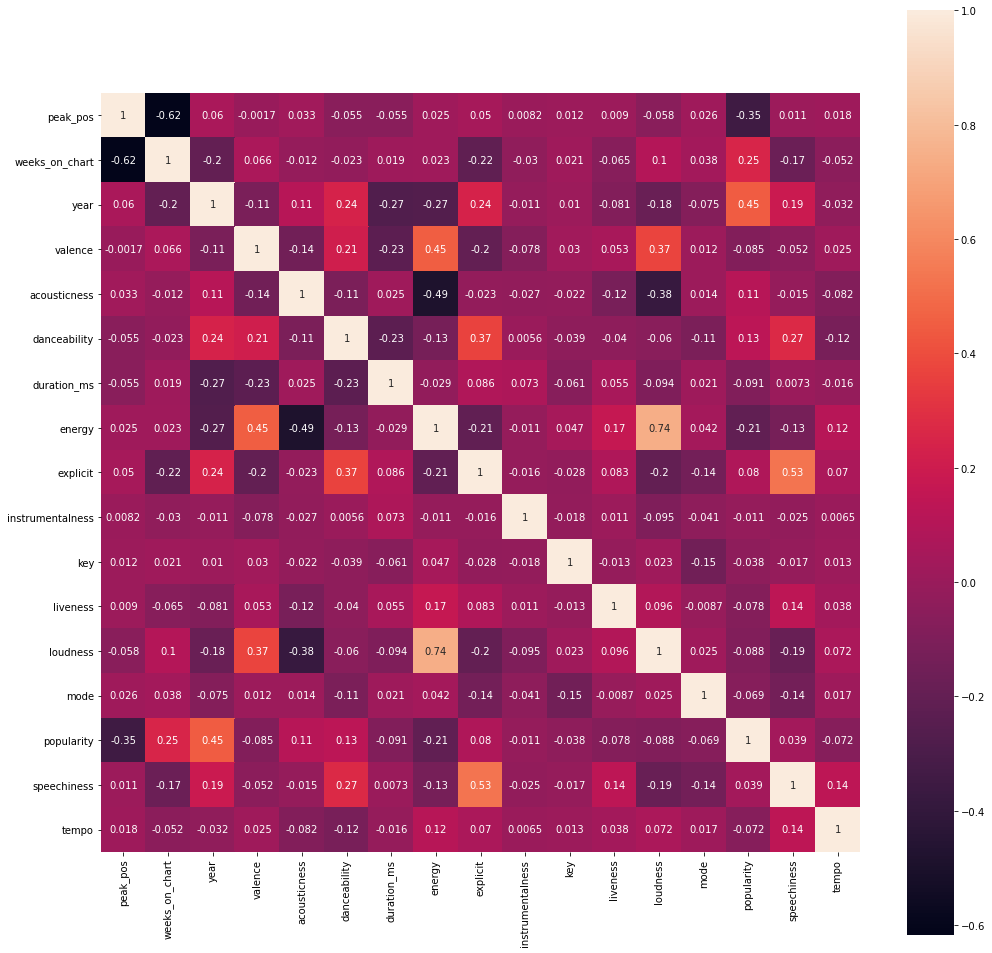

In [204]:
corr = data.corr()
fig, ax = plt.subplots()
fig.set_size_inches(17, 17)
sns.heatmap(corr, annot=True, fmt=".2g", ax=ax, square=True)

[-3.76298224e-04  7.92891913e-02 -6.48604822e+00  2.28040819e+02]
0.12219559349227595


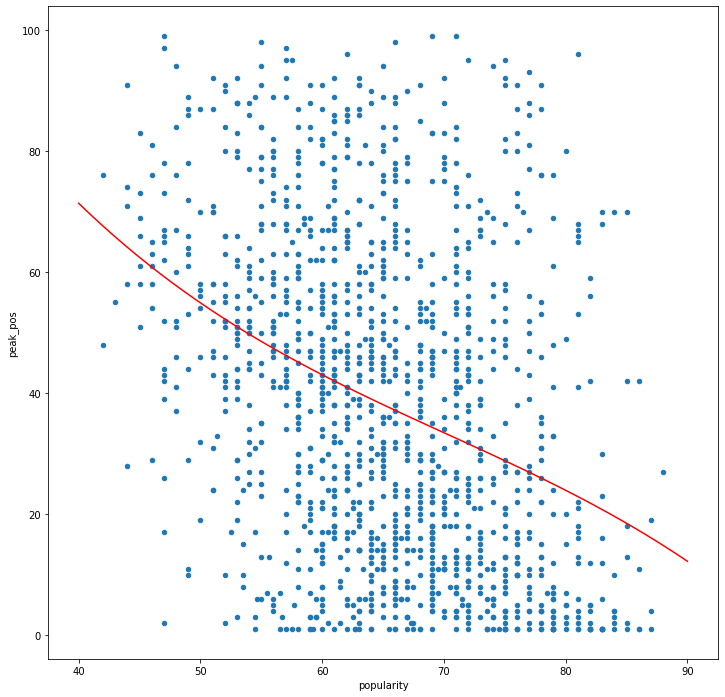

In [206]:
fig = plt.figure()
ax = fig.add_subplot(111)

coeffs = np.polyfit(x = data.popularity, y = data.peak_pos, deg=3)
print(coeffs)


x = data.popularity
y = data.peak_pos

# r-squared
p = np.poly1d(coeffs)
# fit values, and mean
yhat = p(x)                         # or [p(z) for z in x]
ybar = np.sum(y)/len(y)          # or sum(y)/len(y)
ssreg = np.sum((yhat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
sstot = np.sum((y - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
determination = ssreg / sstot
print(determination)
    
X = np.linspace(40, 90, num=100, retstep=True)[0]

plt.plot(X, p(X), 'r')
data.plot(x='popularity', y='peak_pos', kind='scatter', figsize=(12,12), ax=ax)

In [207]:
reg = smf.ols(formula="peak_pos ~ popularity", data=data).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               peak_pos   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     191.2
Date:                Fri, 18 Dec 2020   Prob (F-statistic):           7.79e-41
Time:                        21:43:20   Log-Likelihood:                -6408.9
No. Observations:                1386   AIC:                         1.282e+04
Df Residuals:                    1384   BIC:                         1.283e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    105.0790      4.861     21.618      0.000      95.544     114.614
popularity    -1.0232      0.074    -13.829      0.000      -1.168      -0.878
==============================================================================
Omnibus:                       68.150   Durbin-Watson:                   1.693
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               61.387
Skew:                           0.453   Prob(JB):                     4.68e-14
Kurtosis:                       2.509   Cond. No.                         482.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [208]:
X_train, X_test, y_train, y_test = train_test_split(data['popularity'], data.peak_pos, test_size=0.2)
X_train = X_train.to_numpy().reshape(-1,1)
X_test = X_test.to_numpy().reshape(-1,1)

In [209]:
svr_reg = make_pipeline(StandardScaler(), LinearSVR(random_state=0, tol=1e-5))
svr_reg.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvr', LinearSVR(random_state=0, tol=1e-05))])

In [210]:
score = cross_validate(svr_reg, X_test, y_test, cv=10)
score['test_score'].mean()

-0.18920110573502807

In [239]:
genre_data = data.copy()
genre_data['genre'] = data['genre'].apply(lambda x: x.split(','))

genre_cols = ['peak_pos', 'weeks_on_chart', 'artists', 'name', 'year',
       'valence', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'explicit', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'popularity', 'speechiness', 'tempo']
genre_data = genre_data.set_index(genre_cols)['genre'].apply(pd.Series).stack()
genre_data = genre_data.reset_index()
genre_cols += ['genre_num', 'genre_val']
genre_data.columns = genre_cols
genre_data['count'] = 1
genre_data

,peak_pos,weeks_on_chart,artists,name,year,valence,acousticness,danceability,duration_ms,energy,...,key,liveness,loudness,mode,popularity,speechiness,tempo,genre_num,genre_val,count
0,16,20.0,['5 Seconds of Summer'],Amnesia,2014,0.108,0.0283,0.572,237248.0,0.499,...,2,0.213,-5.237,1,69.0,0.0311,101.593,0,Australia,1
1,16,20.0,['5 Seconds of Summer'],Amnesia,2014,0.108,0.0283,0.572,237248.0,0.499,...,2,0.213,-5.237,1,69.0,0.0311,101.593,1,Punk Rock,1
2,16,20.0,['5 Seconds of Summer'],Amnesia,2014,0.108,0.0283,0.572,237248.0,0.499,...,2,0.213,-5.237,1,69.0,0.0311,101.593,2,Pop-Rock,1
3,16,20.0,['5 Seconds of Summer'],Amnesia,2014,0.108,0.0283,0.572,237248.0,0.499,...,2,0.213,-5.237,1,69.0,0.0311,101.593,3,Pop,1
4,16,20.0,['5 Seconds of Summer'],Amnesia,2014,0.108,0.0283,0.572,237248.0,0.499,...,2,0.213,-5.237,1,69.0,0.0311,101.593,4,Rock,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4338,29,20.0,['Zac Brown Band'],Colder Weather,2010,0.199,0.4550,0.667,273893.0,0.381,...,3,0.116,-7.494,1,68.0,0.0294,135.975,1,Rock,1
4339,35,20.0,['Zac Brown Band'],Keep Me in Mind,2010,0.564,0.1590,0.684,214107.0,0.715,...,6,0.181,-6.132,1,58.0,0.0336,96.018,0,Country,1
4340,35,20.0,['Zac Brown Band'],Keep Me in Mind,2010,0.564,0.1590,0.684,214107.0,0.715,...,6,0.181,-6.132,1,58.0,0.0336,96.018,1,Rock,1
4341,24,15.0,"['will.i.am', 'Nicki Minaj']",Check It Out,2010,0.700,0.0523,0.858,238160.0,0.676,...,3,0.103,-4.835,0,51.0,0.0746,129.991,0,Producer,1


In [240]:
f = {'peak_pos': 'mean',
     'weeks_on_chart': 'mean',
     'valence': 'mean',
     'acousticness': 'mean',
     'danceability': 'mean',
     'duration_ms': 'mean',
     'energy': 'mean',
     'explicit': 'mean',
     'instrumentalness': 'mean',
     'key': 'first',
     'liveness': 'mean',
     'loudness': 'mean',
     'mode': 'mean',
     'popularity': 'mean',
     'speechiness': 'mean',
     'tempo': 'mean',
     'count': 'count'
    }
agg_genre_data = genre_data.groupby('genre_val', as_index = False).agg(f)

In [241]:
plot_genre_data = genre_data[(genre_data['genre_val'] == 'Pop')
                      | (genre_data['genre_val'] == 'Rap')
                      | (genre_data['genre_val'] == 'R&;B')
                      | (genre_data['genre_val'] == 'Country')
                      | (genre_data['genre_val'] == 'Electronic')
                      | (genre_data['genre_val'] == 'Dance')
                      | (genre_data['genre_val'] == 'Rock')
                      | (genre_data['genre_val'] == 'Alternative')
                     ]

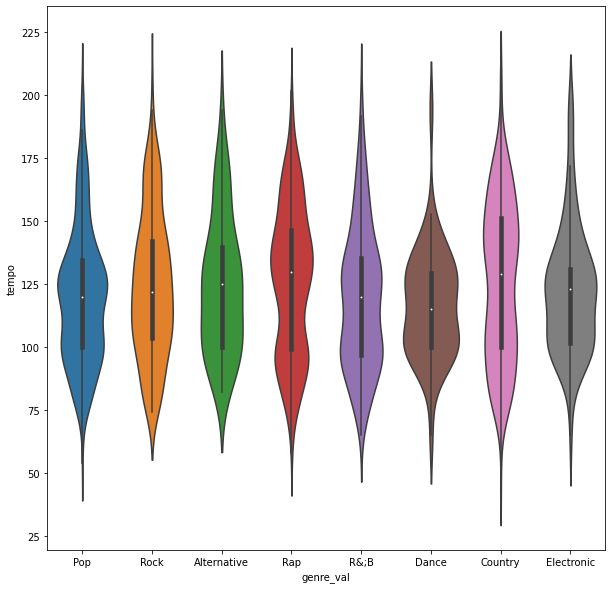

In [242]:
fig, ax = plt.subplots(figsize=(10,10))
sns.violinplot(x="genre_val", y="tempo", data=plot_genre_data, ax=ax)
plt.show()

In [243]:
agg_genre_data = agg_genre_data.sort_values(by='count', ascending=False, ignore_index=True).reset_index().head(30)
agg_genre_data

,index,genre_val,peak_pos,weeks_on_chart,valence,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,count
0,0,Pop,31.291531,19.328990,0.495862,0.168731,0.635963,223146.101927,0.684365,0.193811,0.004749,2,0.179992,-5.736857,0.633550,68.103827,0.081757,119.996641,614
1,1,Rap,38.975207,13.694215,0.441957,0.143667,0.717105,225146.973829,0.645205,0.818182,0.003800,6,0.202517,-6.307738,0.578512,65.092975,0.191679,126.149296,484
2,2,Country,44.371166,17.515337,0.551108,0.181739,0.571138,214851.165644,0.725011,0.003067,0.002117,2,0.165708,-5.517025,0.907975,59.811350,0.044702,126.220592,326
3,3,R&;B,37.754032,16.762097,0.439778,0.197341,0.645777,228467.299395,0.617191,0.407258,0.006974,6,0.168979,-6.439887,0.556452,66.687164,0.104850,119.241176,248
4,4,Rock,40.326360,19.288703,0.519296,0.148225,0.571077,224662.853556,0.745824,0.037657,0.015648,2,0.172941,-5.573897,0.803347,62.583682,0.050289,124.229084,239
5,5,Trap,40.207101,12.958580,0.379459,0.118048,0.766016,212987.366864,0.580552,0.928994,0.005023,11,0.178714,-6.842512,0.550296,68.249507,0.215765,128.753261,169
6,6,Canada,34.364780,13.276730,0.405076,0.171909,0.678700,233026.037736,0.588156,0.672956,0.004158,10,0.183788,-7.287034,0.540881,66.441300,0.179979,122.334998,159
7,7,Electro-Pop,25.774775,20.432432,0.473707,0.112998,0.655174,217026.845345,0.720443,0.144144,0.005454,7,0.188025,-5.698392,0.513514,69.234234,0.087271,117.885860,111
8,8,Pop-Rock,27.666667,23.401961,0.520718,0.118818,0.598328,215922.122549,0.747966,0.058824,0.005915,2,0.172821,-5.285500,0.696078,68.419935,0.060382,122.200837,102
9,9,Electronic,32.075269,19.516129,0.429656,0.118371,0.651452,225403.623656,0.733280,0.118280,0.024086,4,0.193604,-5.416812,0.505376,69.118280,0.080542,122.231349,93


In [244]:
genre_data = genre_data.merge(agg_genre_data[['genre_val', 'index']], on='genre_val')

In [263]:
genre_data = genre_data[genre_data['index'] <= 9]

In [359]:
features = genre_data[['valence',
                       'acousticness',
                       'danceability',
                       'duration_ms',
                       'energy',
                       'explicit',
                       'instrumentalness',
                       'key',
                       'liveness',
                       'loudness',
                       'mode',
                       'popularity',
                       'speechiness',
                       'tempo'
                      ]]
X_train, X_test, y_train, y_test = train_test_split(features, genre_data['index'], test_size=0.2)

In [360]:
y_train

850     4
3239    6
2496    2
2323    2
2672    5
       ..
1321    1
1735    3
819     4
359     0
1338    1
Name: index, Length: 2036, dtype: int64

In [265]:
svc_clf = make_pipeline(StandardScaler(), LinearSVC(random_state=0, tol=1e-5, max_iter = 10000))
svc_clf.fit(X_train, y_train)

/opt/conda/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(max_iter=10000, random_state=0, tol=1e-05))])

In [268]:
score = cross_validate(svc_clf, X_test, y_test, cv=10, scoring='accuracy')

In [270]:
score['test_score'].mean()

0.38501960784313727

In [271]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)
score = cross_validate(rf_clf, X_test, y_test, cv=10, scoring='accuracy')

In [272]:
score['test_score'].mean()

0.29470588235294115

In [283]:
knn_clf = KNeighborsClassifier(n_neighbors=90)
knn_clf.fit(X_train, y_train)
score = cross_validate(knn_clf, X_test, y_test, cv=10, scoring='accuracy')

In [284]:
score['test_score'].mean()

0.2672549019607843

In [286]:
v_clf = VotingClassifier(estimators=[('svc', svc_clf),('rf', rf_clf),('knn', knn_clf)])
v_clf = v_clf.fit(X_train, y_train)
score = cross_validate(v_clf, X_test, y_test, cv=10, scoring='accuracy')

/opt/conda/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [287]:
score['test_score'].mean()

0.3456862745098039

In [295]:
example = [[0.799,
           0.287,
           0.488,
           231467,
           0.855,
           0,
           0,
           7,
           0.132,
           -3.417,
           1,
           52,
           0.0399,
           148.971
          ]]
knn_clf.predict(example)

array([0])

In [311]:
genre_data.genre_val.unique()

array(['Pop-Rock', 'Pop', 'Rock', 'Rap', 'R&;B', 'Electro-Pop', 'Country',
       'Trap', 'Electronic', 'Canada'], dtype=object)

In [321]:
categories = ['Pop-Rock', 'Pop', 'Rock', 'Rap', 'R&;B', 'Electro-Pop', 'Country', 'Trap', 'Electronic', 'Canada']

SVC_pipeline = Pipeline([('clf', OneVsRestClassifier(LinearSVC(max_iter = 10000), n_jobs=1))])

# train the model using X_dtm & y
SVC_pipeline.fit(X_train, y_train)

/opt/conda/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("L

Pipeline(steps=[('clf',
                 OneVsRestClassifier(estimator=LinearSVC(max_iter=10000),
                                     n_jobs=1))])

In [331]:
categories = ['Pop',
             'Rap',
             'Country',
             'R&;B',
             'Rock',
             'Trap',
             'Canada',
             'Electro-Pop',
             'Pop-Rock',
             'Electronic'
             ]

def transform_genres(genre_str):
    genres = genre_str.split(',')
    result = np.zeros(len(categories))
    for genre in genres:
        if genre in categories:
            result[categories.index(genre)] = 1
    return result

training_data = data.copy()
training_data['genre'] = data['genre'].apply(transform_genres)

In [338]:
training_data.head(3)

,peak_pos,weeks_on_chart,genre,artists,name,year,valence,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo
0,16,20.0,"[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...",['5 Seconds of Summer'],Amnesia,2014,0.108,0.02830,0.572,237248.0,0.499,0,0.000000,2,0.2130,-5.237,1,69.0,0.0311,101.593
1,47,3.0,"[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...",['5 Seconds of Summer'],Don't Stop,2014,0.892,0.00209,0.571,169936.0,0.957,0,0.000015,8,0.0425,-3.468,1,57.0,0.0633,149.946
3,34,2.0,"[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...",['5 Seconds of Summer'],Good Girls,2014,0.557,0.01310,0.531,206424.0,0.915,0,0.000000,4,0.1190,-5.215,1,58.0,0.0828,141.060


In [361]:
features = training_data[['valence',
                       'acousticness',
                       'danceability',
                       'duration_ms',
                       'energy',
                       'explicit',
                       'instrumentalness',
                       'key',
                       'liveness',
                       'loudness',
                       'mode',
                       'popularity',
                       'speechiness',
                       'tempo'
                      ]]
X_train, X_test, y_train, y_test = train_test_split(features, training_data.genre, test_size=0.2)

In [366]:
classifier = OneVsRestClassifier(LinearSVC(max_iter=10000))
classifier.fit(X_train, y_train.tolist())
predicted = classifier.predict(X_test)

#for item, labels in zip(X_test, predicted):
#    print '%s => %s' % (item, ', '.join(target_names[x] for x in labels))

/opt/conda/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("L

In [372]:
predicted[4]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 1])

In [415]:
top_path = "./BillboardFromLast20/billboardHot100_1999-2019.csv"
top_data = pd.read_csv(top_path)
top_data = top_data.drop(['Unnamed: 0', 'Writing.Credits', 'Lyrics', 'Features'], axis=1)
top_data.head()

,Artists,Name,Weekly.rank,Peak.position,Weeks.on.chart,Week,Date,Genre
0,"Lil Nas,",Old Town Road,1,1.0,7.0,2019-07-06,"April 5, 2019","Country,Atlanta,Alternative Country,Hip-Hop,Tr..."
1,"Shawn Mendes, Camila Cabello",Senorita,2,NaN,NaN,2019-07-06,"June 21, 2019",Pop
2,Billie Eilish,Bad Guy,3,2.0,13.0,2019-07-06,"March 29, 2019","Hip-Hop,Dark Pop,House,Trap,Memes,Alternative ..."
3,Khalid,Talk,4,3.0,20.0,2019-07-06,"February 7, 2019","Synth-Pop,Pop"
4,"Ed Sheeran, Justin Bieber",I Don't Care,5,2.0,7.0,2019-07-06,"May 10, 2019","Canada,UK,Dance,Dance-Pop,Pop"


In [416]:
top_data['Date'] = pd.to_datetime(top_data['Date'])
top_data['Year'] = top_data['Date'].apply(lambda date: date.year)

In [417]:
f = {'Weekly.rank': 'min', 'Peak.position': 'min', 'Weeks.on.chart': 'max', 'Genre': 'first'}
top_data = top_data.groupby(['Artists', 'Name', 'Year'], as_index = False).agg(f)

In [418]:
top_data['Genre'] = top_data['Genre'].apply(lambda x: x.split(','))
top_data.drop('Weekly.rank', axis=1)

,Artists,Name,Year,Peak.position,Weeks.on.chart,Genre
0,"""Weird Al"" Yankovic",Canadian Idiot,2006.0,82.0,3.0,"[Comedy, Parody, Rock]"
1,"""Weird Al"" Yankovic",Word Crimes,2014.0,39.0,2.0,"[Parody, Comedy, Pop]"
2,'N Sync,Bye Bye Bye,2000.0,4.0,23.0,"[Adult Contemporary, Dance-Pop, Teen Pop, Boy ..."
3,'N Sync,Gone,2001.0,11.0,24.0,"[Adult Contemporary, Acoustic, Soul Pop, R&;B,..."
4,'N Sync,It's Gonna Be Me,2000.0,1.0,25.0,"[Memes, Dance-Pop, Teen Pop, Boy Band, Pop]"
...,...,...,...,...,...,...
6189,will.i.am,Fall Down,2013.0,NaN,NaN,[Rap]
6190,will.i.am,I Got It From My Mama,2007.0,31.0,9.0,[Rap]
6191,will.i.am,It's A New Day,2008.0,78.0,2.0,[Rap]
6192,"will.i.am, Britney Spears",Scream & Shout,2012.0,3.0,24.0,[Rap]


In [419]:
top_cols = ['Artists', 'Name', 'Year', 'Peak.position', 'Weeks.on.chart']
top_data = top_data.set_index(top_cols)['Genre'].apply(pd.Series).stack()
top_data = top_data.reset_index()
top_cols = ['artists', 'name', 'year', 'peak_pos', 'weeks_on_chart', 'genre_num', 'genre']
top_data.columns = top_cols
top_data['count'] = 1
top_data

,artists,name,year,peak_pos,weeks_on_chart,genre_num,genre,count
0,"""Weird Al"" Yankovic",Canadian Idiot,2006.0,82.0,3.0,0,Comedy,1
1,"""Weird Al"" Yankovic",Canadian Idiot,2006.0,82.0,3.0,1,Parody,1
2,"""Weird Al"" Yankovic",Canadian Idiot,2006.0,82.0,3.0,2,Rock,1
3,"""Weird Al"" Yankovic",Word Crimes,2014.0,39.0,2.0,0,Parody,1
4,"""Weird Al"" Yankovic",Word Crimes,2014.0,39.0,2.0,1,Comedy,1
...,...,...,...,...,...,...,...,...
17456,will.i.am,I Got It From My Mama,2007.0,31.0,9.0,0,Rap,1
17457,will.i.am,It's A New Day,2008.0,78.0,2.0,0,Rap,1
17458,"will.i.am, Britney Spears",Scream & Shout,2012.0,3.0,24.0,0,Rap,1
17459,"will.i.am, Nicki Minaj",Check It Out,2010.0,24.0,15.0,0,Producer,1


In [422]:
agg_top_data = top_data.groupby('artists', as_index = False).agg('count')
agg_top_data = agg_top_data.sort_values(by='count', ascending=False, ignore_index=True).reset_index().head(30)
agg_top_data

,index,artists,name,year,peak_pos,weeks_on_chart,genre_num,genre,count
0,0,Glee Cast,721,721,137,137,721,721,721
1,1,Drake,386,386,326,326,386,386,386
2,2,Taylor Swift,215,215,159,159,215,215,215
3,3,Kendrick Lamar,177,177,129,129,177,177,177
4,4,Kanye West,154,154,138,138,154,154,154
5,5,Justin Bieber,153,153,106,106,153,153,153
6,6,The Weeknd,143,143,117,117,143,143,143
7,7,Chris Brown,140,140,128,128,140,140,140
8,8,Fall Out Boy,139,139,95,95,139,139,139
9,9,Eminem,131,131,104,104,131,131,131


In [429]:
plot_top_data = top_data[(top_data['artists'] == 'Glee Cast')
                      | (top_data['artists'] == 'Drake')
                      | (top_data['artists'] == 'Taylor Swift')
                      | (top_data['artists'] == 'Kendrick Lamar')
                      | (top_data['artists'] == 'Kanye West')
                      | (top_data['artists'] == 'Justin Bieber')
                      | (top_data['artists'] == 'The Weeknd')
                      | (top_data['artists'] == 'Chris Brown')
                     ]

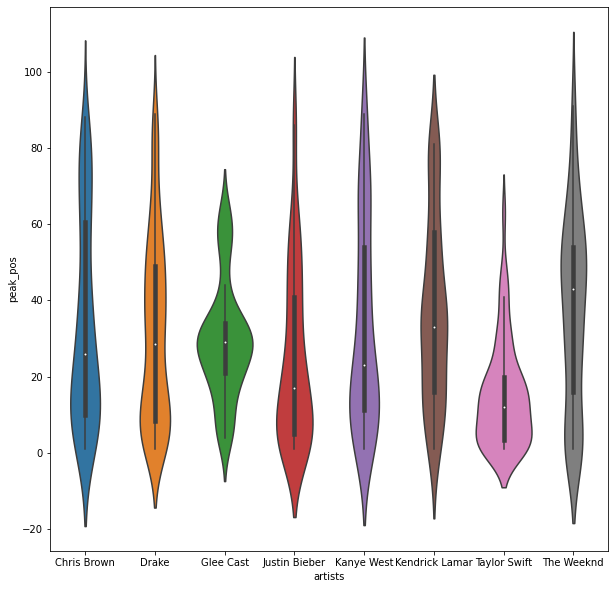

In [430]:
fig, ax = plt.subplots(figsize=(10,10))
sns.violinplot(x="artists", y="peak_pos", data=plot_top_data, ax=ax)
plt.show()